Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load Kaikoura Earthquake Data

In [2]:
def load_data(train_path, dev_path, test_path):
    train_df = pd.read_csv(train_path, sep="\t")
    dev_df = pd.read_csv(dev_path, sep="\t")
    test_df = pd.read_csv(test_path, sep="\t")

    # Combine train data and dev data for better training
    train_df = pd.concat([train_df, dev_df], ignore_index=True)
    return train_df, test_df

train_path = "/content/kaikoura_earthquake_2016_train.tsv"
dev_path = "/content/kaikoura_earthquake_2016_dev.tsv"
test_path = "/content/kaikoura_earthquake_2016_test.tsv"

train_df, test_df = load_data(train_path, dev_path, test_path)

In [3]:
train_df

,tweet_id,tweet_text,class_label
0,798064896545996801,I feel a little uneasy about the idea of work ...,other_relevant_information
1,797913886527602688,#eqnz Interislander ferry docking aborted afte...,caution_and_advice
2,797867944546025472,Much of New Zealand felt the earthquake after ...,other_relevant_information
3,797958935126773760,"Noticing a lot of aftershocks on eqnz site, bu...",sympathy_and_support
4,797813020567056386,"RT @E2NZ: Mike Clements, NZ police, says obvio...",infrastructure_and_utility_damage
...,...,...,...
1755,797798459763990528,RT @BryDeborah: My thoughts and prayers for ev...,sympathy_and_support
1756,797791731982815233,RT @amscraig: Just got text from my work (ANZ)...,other_relevant_information
1757,798096793644990464,Thoughts are with the people/animals affected ...,sympathy_and_support
1758,797871294284865536,Quite a bit of damage and 2 fatalities so far....,injured_or_dead_people


In [4]:
test_df

,tweet_id,tweet_text,class_label
0,798274825441538048,The earthquake in New Zealand was massive. Bil...,infrastructure_and_utility_damage
1,798452064208568320,These pictures show the alarming extent of the...,infrastructure_and_utility_damage
2,797804396767682560,Just woke to news of another earthquake! WTF N...,sympathy_and_support
3,798434862830993408,"When theres an actual earthquake, landslide an...",not_humanitarian
4,797790705414377472,"Tsunami warning for entire East Coast of NZ, b...",caution_and_advice
...,...,...,...
430,797862022595497988,What a night that was. Thankfully no damage to...,other_relevant_information
431,798425325923401728,@We3forDemocracy This is since Extreme M7.5 ea...,caution_and_advice
432,797808377191600128,RT @caity_petersonn: UPDATE: Hanmer Springs -h...,infrastructure_and_utility_damage
433,797961196364124160,RT @Halcyon_Knights: Our thoughts go out to th...,sympathy_and_support


ALL DATA

In [5]:
tweet_data = pd.concat([train_df, test_df], ignore_index=True)

In [6]:
tweet_data['class_label'].value_counts()

,count
class_label,
caution_and_advice,493
sympathy_and_support,432
infrastructure_and_utility_damage,312
other_relevant_information,311
not_humanitarian,224
rescue_volunteering_or_donation_effort,207
injured_or_dead_people,105
displaced_people_and_evacuations,87
requests_or_urgent_needs,24


Data Preprocessing

In [7]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["tweet_text"].apply(clean_text)
test_df["clean_text"] = test_df["tweet_text"].apply(clean_text)

In [8]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

In [9]:
label_mapping = {label: idx for idx, label in enumerate(train_df["class_label"].unique())}
y_train = train_df["class_label"].map(label_mapping)
y_test = test_df["class_label"].map(label_mapping)

Define confusion matrix

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels", fontsize=10)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=10)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

class_labels = list(label_mapping.keys())


In [11]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

Decision Tree

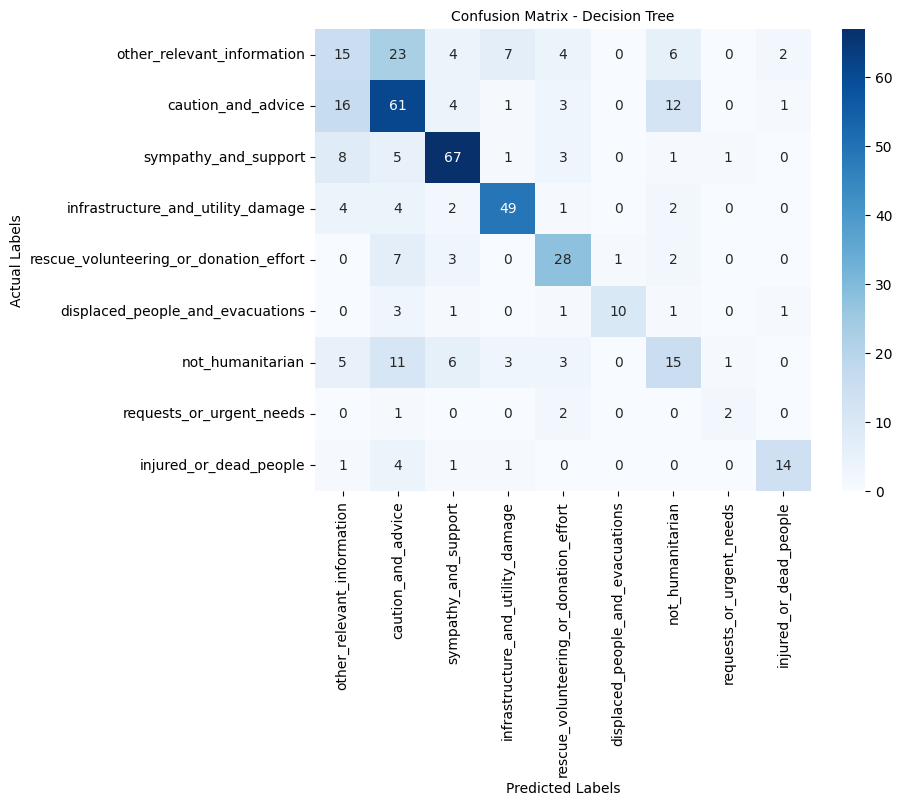


Decision Tree Evaluation:
Accuracy: 0.6
Precision: 0.5979496621948085
F1 Score: 0.5954168142662568

 Classification Report:
                                        precision    recall  f1-score   support

            other_relevant_information       0.31      0.25      0.27        61
                    caution_and_advice       0.51      0.62      0.56        98
                  sympathy_and_support       0.76      0.78      0.77        86
     infrastructure_and_utility_damage       0.79      0.79      0.79        62
rescue_volunteering_or_donation_effort       0.62      0.68      0.65        41
      displaced_people_and_evacuations       0.91      0.59      0.71        17
                      not_humanitarian       0.38      0.34      0.36        44
              requests_or_urgent_needs       0.50      0.40      0.44         5
                injured_or_dead_people       0.78      0.67      0.72        21

                              accuracy                           0.60    

In [12]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

plot_confusion_matrix(y_test, dt_preds, "Decision Tree", class_labels)
evaluate_model(y_test, dt_preds,"Decision Tree")


Random Forest

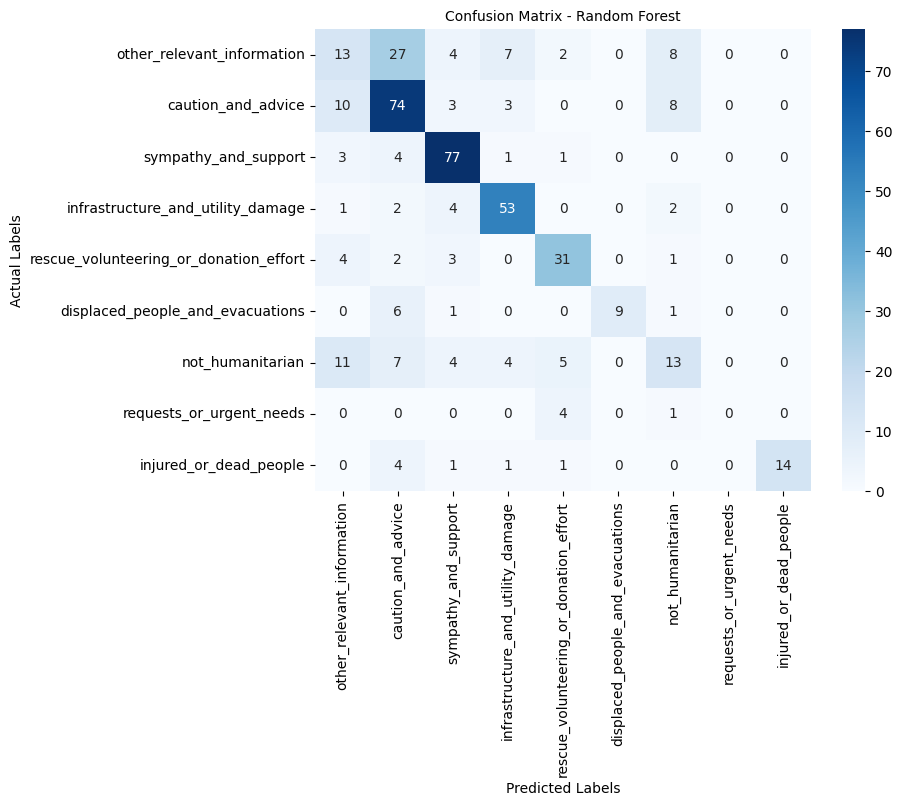


Random Forest Evaluation:
Accuracy: 0.6528735632183909
Precision: 0.6345692658104525
F1 Score: 0.634090486602338

 Classification Report:
                                        precision    recall  f1-score   support

            other_relevant_information       0.31      0.21      0.25        61
                    caution_and_advice       0.59      0.76      0.66        98
                  sympathy_and_support       0.79      0.90      0.84        86
     infrastructure_and_utility_damage       0.77      0.85      0.81        62
rescue_volunteering_or_donation_effort       0.70      0.76      0.73        41
      displaced_people_and_evacuations       1.00      0.53      0.69        17
                      not_humanitarian       0.38      0.30      0.33        44
              requests_or_urgent_needs       0.00      0.00      0.00         5
                injured_or_dead_people       1.00      0.67      0.80        21

                              accuracy                     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

plot_confusion_matrix(y_test, rf_preds, "Random Forest", class_labels)
evaluate_model(y_test, rf_preds,"Random Forest")

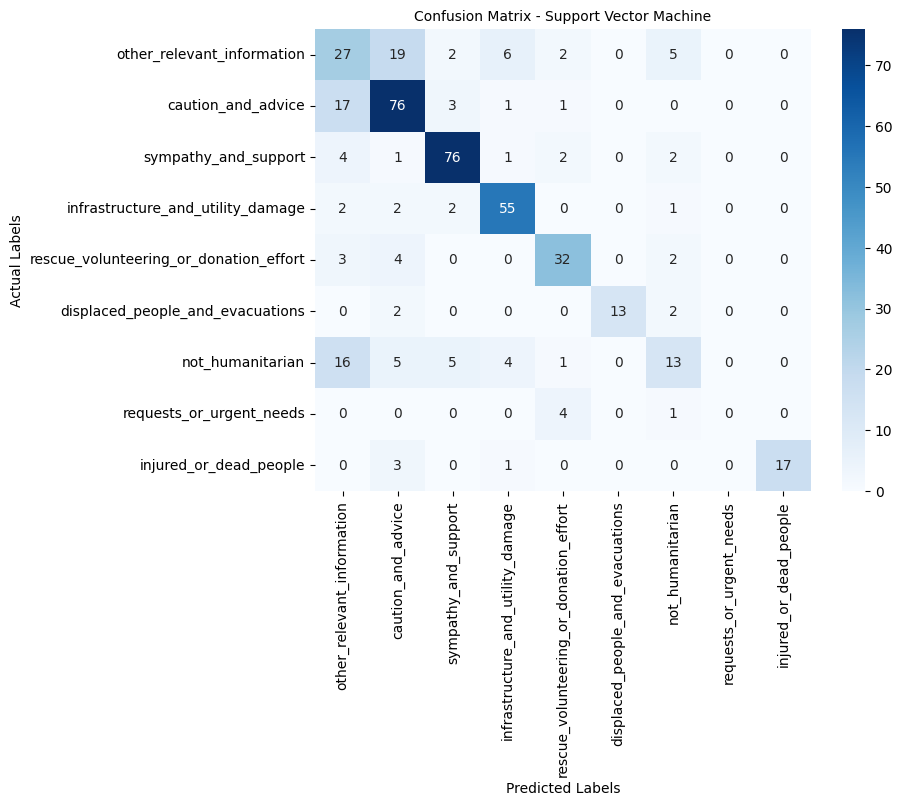


Support Vector Machine Evaluation:
Accuracy: 0.7103448275862069
Precision: 0.7035113713833179
F1 Score: 0.7019307864521123

 Classification Report:
                                        precision    recall  f1-score   support

            other_relevant_information       0.39      0.44      0.42        61
                    caution_and_advice       0.68      0.78      0.72        98
                  sympathy_and_support       0.86      0.88      0.87        86
     infrastructure_and_utility_damage       0.81      0.89      0.85        62
rescue_volunteering_or_donation_effort       0.76      0.78      0.77        41
      displaced_people_and_evacuations       1.00      0.76      0.87        17
                      not_humanitarian       0.50      0.30      0.37        44
              requests_or_urgent_needs       0.00      0.00      0.00         5
                injured_or_dead_people       1.00      0.81      0.89        21

                              accuracy           

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [14]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

plot_confusion_matrix(y_test, svm_preds, "Support Vector Machine", class_labels)
evaluate_model(y_test, svm_preds,"Support Vector Machine")